In [1]:
import atmozon as atz
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp

In [5]:
atm = atz.Atmosphere(
    dt = 0.005,
    beta = 1.0,
    mu = 0.018,
    nu = 1e-14,
    p = 4,
    kf = 32.0,
    dk = 1.0,
    f_amp = 1e-3,
)
grid = atz.Grid(N=256)

In [6]:
N = 100
for _ in range(1):
    grid.calc(atm, steps=N)
    print(f"t = {grid.T}, R_beta = {grid.R_beta}")

t = 1.5, R_beta = 0.14487572014331818


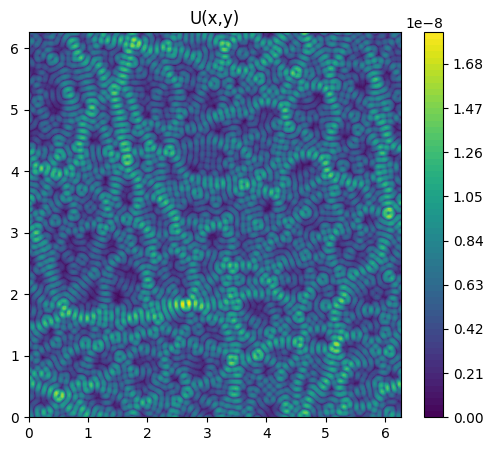

In [7]:
plt.figure(figsize=(6,5))
plt.contourf(np.array(grid.X), np.array(grid.Y), np.array(grid.U), levels=60)
plt.colorbar()
plt.title("U(x,y)")
plt.show()

In [ ]:
for _ in range(20):
    N = 1_000
    grid.calc(atm, steps=N)
    print(f"t = {grid.T}, R_beta = {grid.R_beta}")

In [ ]:
# N = 1000
# start = time.perf_counter()
# grid.calc(atm, steps=N)
# end = time.perf_counter()
# print(end-start)

27.173854123000638
